In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [3]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
        
    plt.figure(figsize=(n_cols, n_rows))
    
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [4]:
codings_size = 30

generator = keras.models.Sequential([
            keras.layers.Dense(100, activation='selu', input_shape=[codings_size]),
            keras.layers.Dense(150, activation='selu'),
            keras.layers.Dense(28*28, activation='sigmoid'),
            keras.layers.Reshape([28, 28])
            ])

discriminator = keras.models.Sequential([
 keras.layers.Flatten(input_shape=[28, 28]),
 keras.layers.Dense(150, activation="selu"),
 keras.layers.Dense(100, activation="selu"),
 keras.layers.Dense(1, activation="sigmoid")
])

gan = keras.models.Sequential([generator, discriminator])

In [5]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")

# trainable : 모델을 컴파일할 때만 영향을 미치는 속성
discriminator.trainable = False

gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [6]:
# fit()을 사용할 수 없기 때문에 사용자 정의 훈련 반복문 필요
batch_size = 32

dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [7]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
 
    for epoch in range(n_epochs):
        for X_batch in dataset:
            # 단계 1 - 판별자 훈련
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
 
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            
            # 타겟 y1: 가짜 이미지일 경우 0, 진짜 이미지일 경우 1
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
 
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
 
            # 단계 2 - 생성자 훈련
            noise = tf.random.normal(shape=[batch_size, codings_size])
            
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
    
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)                     # not shown
        plt.show()  

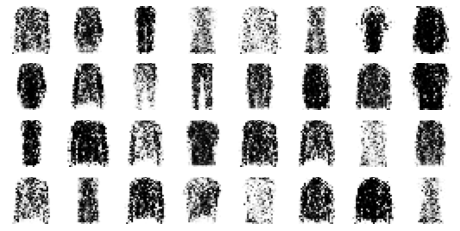

In [8]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

In [ ]:
# epoch 수 늘려도 위보다 더 좋은 이미지는 생성되지 않음